## Make Standardized Maps (Z Scores)
### CSU REU Summer 2024 - Sarah Gryskewicz
These will make data easier to read. </p>
Note: A standardized anomaly, often referred to simply as a standard anomaly, is a statistical term used to express how much a particular observation deviates from the mean (average) of a dataset, in units of standard deviation. It is calculated by subtracting the mean of the dataset from the observation, and then dividing the result by the standard deviation of the dataset. </p>
**Standard Deviation (Z-score of ±1):Indicates a typical or normal fluctuation.** </p>

**Standard Deviations (Z-score of ±2): Indicates that the observation is relatively rare compared to the normal distribution of the data.** </p>

**Standard Deviations (Z-score of ±3): Indicates that the observation is rare and may indicate outliers or events that are far outside the norm.** </p>
****

In [2]:
import io
import requests
import shapefile
import shapely
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib as mplt
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from urllib.request import urlopen, Request
from PIL import Image
from datetime import datetime, timedelta,timezone
import pytz
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pylab as pl 
import numpy as np
from metpy.plots import USCOUNTIES
import matplotlib.ticker as mticker
import cartopy.mpl.gridliner 
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import os, sys, glob, os.path
from matplotlib import rcParams
from matplotlib import rc
rc('mathtext', default='regular') 
rcParams['font.family'] = 'Tahoma'
#rcParams['font.size'] = 14
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'Tahoma'

## Import, Remove, Separate, Split

In [4]:
df = pd.read_csv(r"C:\Users\C837388336\Desktop\REU\Data files\Massive Files\2012_2023_df.txt")
# inorganics
df.loc[df['ammNO3f_Val'] < 0, 'ammNO3f_Val']=np.nan
df.loc[df['ammSO4f_Val'] < 0, 'ammSO4f_Val']=np.nan
df.loc[df['SeaSaltf_Val'] < 0, 'SeaSaltf_Val']=np.nan

# organics
df.loc[df['OMCf_Val'] < 0, 'OMCf_Val']=np.nan
df.loc[df['ECf_Val'] < 0, 'ECf_Val']=np.nan
df.dropna(axis=0,how='any',inplace=True,ignore_index=True)


df['month']=None
df['year']=None
df['Date']=pd.to_datetime(df.Date).copy()
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year

# get sitenames
sitenames=df['SiteCode'].unique()
print(sitenames)

# only use values from june and july
df = df[(df['month'] == 6) | (df['month'] == 7)]

# separate the years into 2011-2022 and 2023
df_others=df.loc[df.year != 2023].copy()
df_year=df.loc[df.year == 2023].copy()

# make df_climo by the site, month, year and state as well as take the mean of the monthly values. the year is also averaged, but it's fine
df_climo=df.groupby(['SiteCode','month']).mean(numeric_only=True)
df_climo.reset_index(inplace=True)

df_2023 = df_year.groupby(['SiteCode','month']).mean(numeric_only=True)
df_2023.reset_index(inplace = True)

['ACAD1' 'BRIG1' 'CABA1' 'CACO1' 'DOSO1' 'EGBE1' 'FRRE1' 'GRGU1' 'LOND1'
 'LYEB1' 'MAVI1' 'MOMO1' 'MOOS1' 'PACK1' 'PENO1' 'PITT1' 'PRIS1']


In [5]:
df.loc[(df.SiteCode == 'MOMO1') & (df.Date == '2023-06-08')]['OMCf_Val']

2673    32.2364
Name: OMCf_Val, dtype: float64

## Work with climo data & 2023 data

In [7]:
# identify the months of interest across all sites from climatology (2018-2022)
df_climo_june = df_climo[df_climo['month'] == 6]
df_climo_july = df_climo[df_climo['month'] == 7]

# identify the months of interest across all sites from 2023
df_2023_june = df_2023[df_2023['month'] == 6]
df_2023_july = df_2023[df_2023['month'] == 7]

In [8]:
# calculate climatological June & July standard deviations for each SiteCode
temp=df.groupby(['SiteCode','month', 'year']).mean(numeric_only=True)
temp.reset_index(inplace=True)

temp2 = temp.groupby(['SiteCode','month']).std(numeric_only=True)
temp2['climo_std']=temp2['OMCf_Val']

temp2.reset_index(inplace=True)
temp2.loc[temp2.SiteCode == 'MOMO1']['OMCf_Val']

22    1.592787
23    1.024406
Name: OMCf_Val, dtype: float64

In [9]:
# merge 2023 values with temp std values. do this for june and july separately so that data is associated w/ the correct dates
df_2023_june=pd.merge(df_2023_june,temp2.loc[temp2['month'] == 6],left_on='SiteCode',right_on='SiteCode',how='left')
df_2023_july=pd.merge(df_2023_july,temp2.loc[temp2['month'] == 7],left_on='SiteCode',right_on='SiteCode',how='left')

df_2023_july

,SiteCode,month_x,POC_x,Latitude_x,Longitude_x,Elevation_x,ammNO3f_Val_x,ammSO4f_Val_x,ECf_Val_x,OMCf_Val_x,...,ammSO4f_Val_y,ECf_Val_y,OMCf_Val_y,RCTM_Val_y,MF_Val_y,CM_calculated_Val_y,RCFM_Val_y,SeaSaltf_Val_y,SOILf_Val_y,climo_std
0,ACAD1,7,1.0,44.37710,-68.26100,157.3333,0.095534,0.782879,0.154601,2.518101,...,0.187569,0.059258,0.787200,1.418137,1.049623,0.802893,0.826656,0.055308,0.058600,0.787200
1,BRIG1,7,1.0,39.46500,-74.44920,5.0000,0.411370,1.969858,0.327445,5.419732,...,0.774120,0.076698,1.006026,148.588611,49.233482,147.378774,49.014542,0.084780,48.148480,1.006026
2,CABA1,7,1.0,43.83250,-70.06440,26.7500,0.202407,0.885094,0.325913,4.535328,...,0.209575,0.071650,0.722821,55.041351,54.467800,54.338443,54.460080,0.136337,53.764768,0.722821
3,CACO1,7,1.0,41.97580,-70.02420,49.0000,0.278919,1.212962,0.239296,3.363576,...,0.416773,0.056165,0.775952,197.867972,64.256829,196.738783,64.165785,0.247184,64.115223,0.775952
4,DOSO1,7,1.0,39.10530,-79.42610,1182.3333,0.251560,1.965777,0.317559,4.672525,...,0.889710,0.078988,0.999498,52.756265,33.376050,52.374721,1.180921,0.013081,0.257609,0.999498
5,EGBE1,7,1.0,44.23115,-79.78322,251.0000,0.425783,1.348633,0.488746,6.328753,...,0.799738,0.099070,1.298664,147.541291,2.149116,146.370272,1.635358,0.012397,0.060531,1.298664
6,FRRE1,7,1.0,39.70580,-79.01220,767.0000,0.160514,2.109391,0.412505,4.702480,...,0.905561,0.078724,0.835465,58.501908,28.698425,57.961074,28.815859,0.009330,28.899351,0.835465
7,GRGU1,7,1.0,44.30820,-71.21770,453.5000,0.046927,0.751436,0.246308,4.957446,...,0.354724,0.052150,0.795697,100.701400,1.380622,100.146499,0.947018,0.008068,0.059835,0.795697
8,LOND1,7,1.0,42.86240,-71.38010,124.0000,0.149749,0.993816,0.430695,6.159663,...,0.361508,0.087979,1.032044,145.902890,145.373740,145.204777,145.152608,0.045260,144.500775,1.032044
9,LYEB1,7,1.0,42.95610,-72.90980,882.0900,0.209344,1.102401,0.362621,6.027415,...,0.469914,0.070143,1.174946,50.627358,46.602197,49.907616,46.479141,0.010652,45.815467,1.174946


In [10]:
temp.loc[(temp.SiteCode == 'MOMO1') & (temp.month == 7)]['OMCf_Val'].values.std()

0.980794256149119

In [11]:
temp2.loc[(temp2.SiteCode == 'MOMO1') & (temp2.month == 7)]['OMCf_Val']

23    1.024406
Name: OMCf_Val, dtype: float64

In [12]:
# objects for the dataframe to work with
dataframe_2023 = df_2023_july
dataframe_climo = df_climo_july
# merge means from 2023 to climo to have a df built with the means and std values
temp2 = pd.merge(dataframe_climo, dataframe_2023, left_on='SiteCode', right_on='SiteCode')
temp2

,SiteCode,month,POC,Latitude,Longitude,Elevation,ammNO3f_Val,ammSO4f_Val,ECf_Val,OMCf_Val,...,ammSO4f_Val_y,ECf_Val_y,OMCf_Val_y,RCTM_Val_y,MF_Val_y,CM_calculated_Val_y,RCFM_Val_y,SeaSaltf_Val_y,SOILf_Val_y,climo_std
0,ACAD1,7,1.0,44.37710,-68.26100,157.3333,0.172777,0.931016,0.177722,2.762229,...,0.187569,0.059258,0.787200,1.418137,1.049623,0.802893,0.826656,0.055308,0.058600,0.787200
1,BRIG1,7,1.0,39.46500,-74.44920,5.0000,0.359918,2.207338,0.288580,3.385289,...,0.774120,0.076698,1.006026,148.588611,49.233482,147.378774,49.014542,0.084780,48.148480,1.006026
2,CABA1,7,1.0,43.83250,-70.06440,26.7500,0.255523,0.995851,0.298830,3.473757,...,0.209575,0.071650,0.722821,55.041351,54.467800,54.338443,54.460080,0.136337,53.764768,0.722821
3,CACO1,7,1.0,41.97580,-70.02420,49.0000,0.335324,1.634636,0.217791,2.956309,...,0.416773,0.056165,0.775952,197.867972,64.256829,196.738783,64.165785,0.247184,64.115223,0.775952
4,DOSO1,7,1.0,39.10530,-79.42610,1182.3333,0.208790,2.511065,0.231371,2.814172,...,0.889710,0.078988,0.999498,52.756265,33.376050,52.374721,1.180921,0.013081,0.257609,0.999498
5,EGBE1,7,1.0,44.23115,-79.78322,251.0000,0.362329,1.655429,0.302674,3.418902,...,0.799738,0.099070,1.298664,147.541291,2.149116,146.370272,1.635358,0.012397,0.060531,1.298664
6,FRRE1,7,1.0,39.70580,-79.01220,767.0000,0.164595,2.638918,0.285869,2.893772,...,0.905561,0.078724,0.835465,58.501908,28.698425,57.961074,28.815859,0.009330,28.899351,0.835465
7,GRGU1,7,1.0,44.30820,-71.21770,453.5000,0.052917,0.922463,0.176427,3.168035,...,0.354724,0.052150,0.795697,100.701400,1.380622,100.146499,0.947018,0.008068,0.059835,0.795697
8,LOND1,7,1.0,42.86240,-71.38010,124.0000,0.187591,1.221868,0.315591,3.785109,...,0.361508,0.087979,1.032044,145.902890,145.373740,145.204777,145.152608,0.045260,144.500775,1.032044
9,LYEB1,7,1.0,42.95610,-72.90980,882.0900,0.186026,1.358514,0.200692,2.895740,...,0.469914,0.070143,1.174946,50.627358,46.602197,49.907616,46.479141,0.010652,45.815467,1.174946


## Transition to the computation
*To do this, you need to sort through the sites and plot the june (or JA) anomalies* </p>
   >**x = (x_2023 - x_climo) / sx** </p>
x = standardized anomaly </p>
x_2023 = 2023 mean for month </p>
x_climo = climatological monthly mean </p>
sx = climatological standard deviation 

In [13]:
# make a new column in temp2 and a list to work with in the upcoming cells
temp2['Z'] = None
x_values = []

for i, sitename in enumerate(sitenames):
    # OMCf_Val_x = 2023 values
    x_2023 = temp2.loc[temp2.SiteCode == sitename]['OMCf_Val_x']
    # OMCf_Val = 2012-2023 avg values
    x_bar = temp2.loc[temp2.SiteCode == sitename]['OMCf_Val']
    # climo_std = standard deviations for 2012-2023
    sx = temp2.loc[temp2.SiteCode == sitename]['climo_std']

    
    # calculate z-scores
    x = ((x_2023 - x_bar) / sx )
    print('Standardized anomaly at ', sitename, ': ', x)

    # add these values to a list to then transition them into the df
    x_values.append(float(x))
temp2['Z'] = x_values

Standardized anomaly at  ACAD1 :  0   -0.310122
dtype: float64
Standardized anomaly at  BRIG1 :  1    2.022257
dtype: float64
Standardized anomaly at  CABA1 :  2    1.46865
dtype: float64
Standardized anomaly at  CACO1 :  3    0.52486
dtype: float64
Standardized anomaly at  DOSO1 :  4    1.859285
dtype: float64
Standardized anomaly at  EGBE1 :  5    2.240649
dtype: float64
Standardized anomaly at  FRRE1 :  6    2.164912
dtype: float64
Standardized anomaly at  GRGU1 :  7    2.248861
dtype: float64
Standardized anomaly at  LOND1 :  8    2.300828
dtype: float64
Standardized anomaly at  LYEB1 :  9    2.665378
dtype: float64
Standardized anomaly at  MAVI1 :  10   -0.656819
dtype: float64
Standardized anomaly at  MOMO1 :  11    2.868906
dtype: float64
Standardized anomaly at  MOOS1 :  12   -1.019298
dtype: float64
Standardized anomaly at  PACK1 :  13    2.815874
dtype: float64
Standardized anomaly at  PENO1 :  14    1.410621
dtype: float64
Standardized anomaly at  PITT1 :  15    1.211272
dty

In [14]:
avg_dev_NE = np.average(temp2['Z'])
avg_dev_NE

1.4421511023118403

## Make a map
Use what was just calculated (z score) to plot the anomalies by the IMPROVE colored boxes

In [27]:
# This is a function that I found that allows me to spoof that this is not a Python script (this is to get a nice map background)
# I did not write this
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

# set map bounds
    #Transport and regular map bounds:
map_bounds = [-84, -65, 37, 48]
#map_bounds =[-92, -65, 32, 47]

streetmap='True'

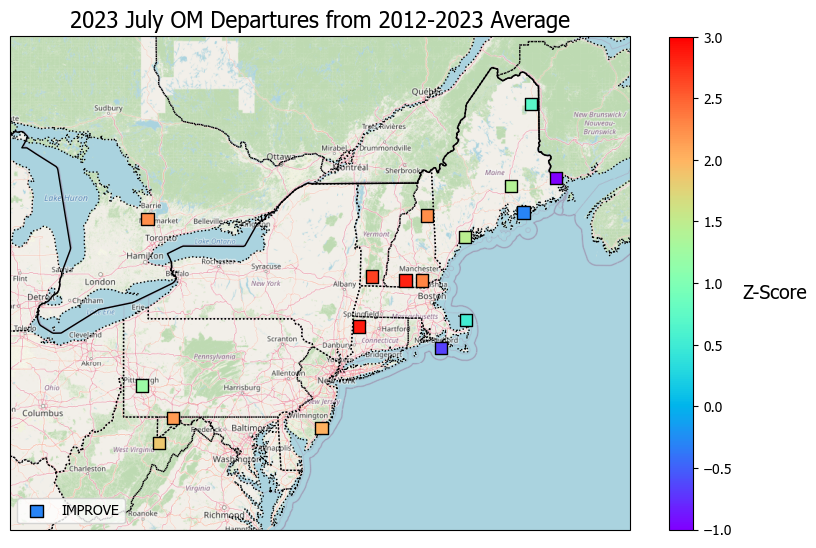

In [29]:
# change df_new depending on the month youre looking at
df_new = temp2

start_datetime=datetime.strptime("07-01-2023", "%m-%d-%Y")
end_datetime=datetime.strptime("07-01-2023", "%m-%d-%Y")

for x in range(0, 1+(end_datetime-start_datetime).days):
    plt.close('all')
    date2grab=start_datetime + timedelta(days=x)
    figure_title='2023 July OM Departures from 2012-2023 Average'

    
        # Plot the map with fire location and smoke plumes
    if (streetmap == 'True'):
     cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
     osm_img = cimgt.OSM()             # spoofed, downloaded street map
     fig = plt.figure(figsize=(10,8))      # open matplotlib figure
     rect = fig.patch
     rect.set_facecolor("white")
     m = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
     extent = map_bounds
     m.set_extent(extent) # set extents
     scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) # empirical solve for scale based on zoom
     scale = (scale<20) and scale or 19 # scale cannot be larger than 19
     m.add_image(osm_img, int(scale)) # add OSM with zoom specification

    else: 
     fig=plt.figure(figsize=(10,8))
     fig.set_facecolor('whitesmoke')
     rect = fig.patch
     rect.set_facecolor("white")
     m = plt.axes(projection=ccrs.PlateCarree())
     m.add_feature(cfeature.LAND)
     m.add_feature(cfeature.OCEAN, alpha=0.5)
     m.add_feature(cfeature.COASTLINE)
     m.set_extent(map_bounds, ccrs.PlateCarree()) 

    
    m.add_feature(cfeature.BORDERS)       
    m.add_feature(cfeature.STATES, linestyle=':')

    cs=m.scatter(df_new['Longitude_x'],df_new['Latitude_x'],c=df_new['Z'],marker='s',s=80,cmap='rainbow', \
              vmax=3,vmin=-1,edgecolor='black',transform=ccrs.PlateCarree(),label='IMPROVE',zorder=4)    

    
    plt.legend(loc=3)
    
    transform = ccrs.PlateCarree()._as_mpl_transform(m) # set transform for annotations
    cax,kw = mplt.colorbar.make_axes(m,location='right',pad=0.05,shrink=0.8)
    cbar = plt.colorbar(cs,cax=cax,**kw)
    cbar.ax.tick_params(axis='y', labelsize=10)
    cbar.set_label('Z-Score', fontsize=14, rotation = 0, labelpad=30)
    
    m.set_title(figure_title,fontsize=16)
    plt.show()

#fig.savefig('/Users/C837388336/Desktop/REU/Data files/Saved Plots/Maps/2012-2023 Departures/2023 July Departures OM.png')